#  imports

In [1]:
import pygeostat as gs
import gglib as gg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
import rmutils as rm
from gglib.datamgmt.simpleio import *
%matplotlib inline

The imports are copied to the clipboard


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
rm.mpl_setup()
import spatialcluster as sp

In [4]:
variables = ['Ni', 'Fe', 'SiO2', 'MgO']
nsvariables = [f'NS_{v}' for v in variables]

In [5]:
sys.path.insert(0, '../')
import validator.crossval as cv
import validator.validation_utils as vf
import validator.error_functions as ef
import validator.exporter as exp
exp.init_project('nilat_')

# parameters

In [6]:
masterseed = 201904
declus_cellsize = 50
saveplots = True
rng = np.random.RandomState(masterseed)
seeds = rng.permutation(2500)[:500]
ltrim = -999
searchparams = (50, 0, 0, 800, 600, 10)
nprocesses = 6
nreal = 100

workdir = 'L:/PhD-Wrapup/Nilat/sim/'
gs.ensure_path(workdir)

In [7]:
catvarmodels = gg.load_pickle('catvarmodels.pkl')
nsvarmodels = gg.load_pickle('nsvarmodels.pkl')

In [8]:
points = gg.PointContainer('nilat_maincats.dat')

griddef = gg.GridDef(open('griddef', 'r').read())
print(griddef)

92 1879.81 10.0 
99 8953.94 10.0 
23 896.36 2.0


# declustering weights

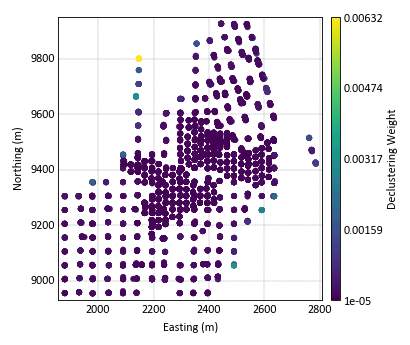

In [9]:
declus = gg.PolyDecluster(points, griddef.convert_to_2d(),
                          dhcol=points.dh)
points['Declustering Weight'] = declus.decluster()
points['Declustering Weight'] /= points['Declustering Weight'].sum()
ax = gs.locmap(points, var='Declustering Weight', 
               cbar_label='Declustering Weight')

In [10]:
def get_pvalue(data, p=90):
    """ get the specified z corresponding to the provided p value """
    z, F = gs.cdf(data)
    return np.interp(p / 100, F, z)

In [11]:
pval = get_pvalue(points['Declustering Weight'], 96)
points.loc[points['Declustering Weight'] > pval, 'Declustering Weight'] = pval

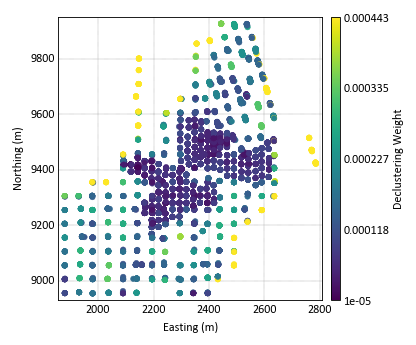

In [12]:
ax = gs.locmap(points, var='Declustering Weight', 
               cbar_label='Declustering Weight')

# checks

In [13]:
names = ['modelcats', 'mvclus', 'betteragglom', 'reals_ensbest']
titles = ["Geological Categories", "Multivariate Clusters", 
          "Improved Spatial Clusters", "Category Realizations"]
names = dict([(k, t) for k, t in zip(names, titles)])

## histograms - NS

## histograms - original units

In [14]:
reference_dists = gs.read_gsb(f'{workdir}modelcats/Final/mergedbtr_{25}.gsb').loc[::10]

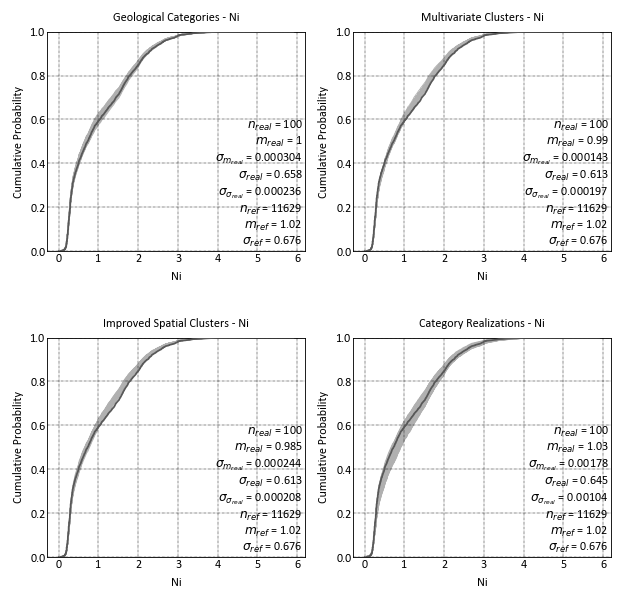

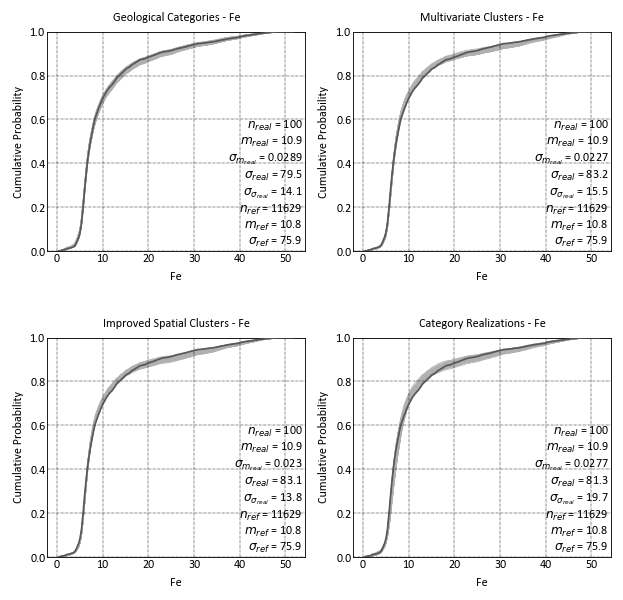

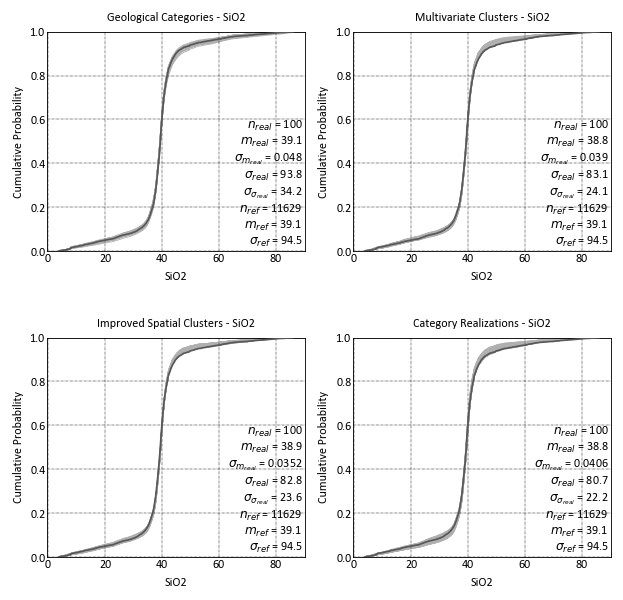

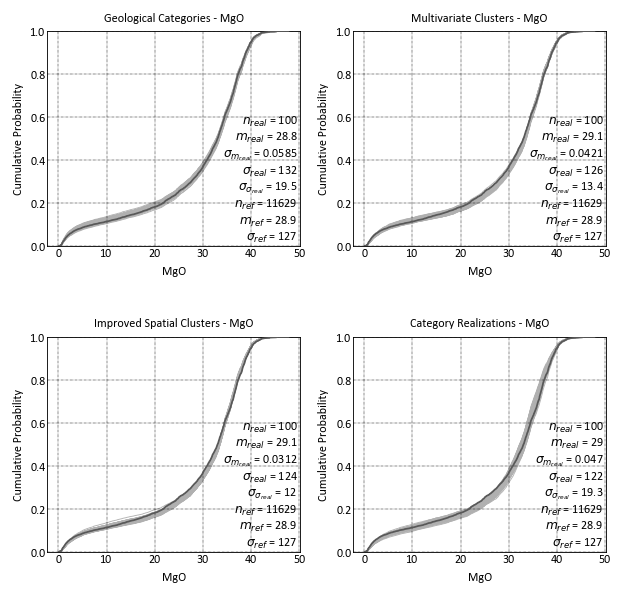

In [15]:
for var in variables:
    f, axs = plt.subplots(2, 2, figsize=(5, 5))
    for (name, title), ax in zip(names.items(), axs.flatten()):    
        allreals = [gs.read_gsb(f'{workdir}{name}/Final/mergedbtr_{ireal}.gsb')[var]
                    for ireal in range(nreal)]
        allreals = pd.concat(allreals, axis=1)
        allreals.columns = [f'{var}_{ireal}' for ireal in range(nreal)]
        
        gg.histpltsim(allreals, 
                      reference_dists[var][reference_dists[var] > -1], 
                      ax=ax)
        
        ax.set_title(f'{title} - {var}')
        ax.set_ylabel('Cumulative Probability')
        ax.set_xlabel(var)
    plt.tight_layout()
    exp.exportfigure(f'{var}_hist_reproduction.pdf')

# variograms

## Experimental Points

In [16]:
import sys; sys.path.insert(0, 'C:/GIT/python-local/variograms/')

In [17]:
import variograms
variograms.__file__

'C:/GIT/python-local/variograms\\variograms\\__init__.py'

In [30]:
vario_type = 4

In [31]:
expvarios = {}
for var in variables:
    expvarios[var] =  variograms.VarCalc(points, var, itype=vario_type,
                                         ndir=2, lagdist=[50, 2], lagtol=[25, 1], 
                                         diptol=10.5, bandvert=3).calc()

## vario reproduction

In [32]:
varsim = gs.Program('varsim')
varsimpar = """START OF PARAMETERS:
    nodata               -file with lithology information
    0   7                        -   lithology column (0=not used), code
    {datfl}                   -file with data
    {nvar}   {varcols}            -   number of variables, column numbers
    {ltrim}     1.0e21    -   trimming limits
    {outfl}      -output file for variograms of realizations
    {avgfl}        -output file for average variogram
    {griddef}
     1                  -number of realizations
    2  15                 -number of directions, number of lags
     3  2  0              -ixd(1),iyd(1),izd(1)
     0  0  1              -ixd(2),iyd(2),izd(2)
    1                     -standardize sill? (0=no, 1=yes)
    {nvario}                     -number of variograms
    {variotypes}
"""
vartemp = """{}   {}   {}             -tail variable, head variable, variogram type"""

In [33]:
results = {}
for name, title in gg.log_progress(names.items()):
    parallelpars = []
    for ivar, var in enumerate(variables): 
        for ireal in range(nreal):
            fmtpar = varsimpar.format(
                datfl=f'{workdir}{name}/Final/mergedbtr_{ireal}.gsb',
                nvar=1, varcols=ivar + 1, 
                ltrim=-998, 
                outfl=f'{workdir}{name}/Final/varsim_{var}_{ireal}.out',
                avgfl=f'{workdir}{name}/Final/varsimavg_{var}_{ireal}.out',
                griddef=griddef,
                nvario=1, variotypes=vartemp.format(1, 1, vario_type)
            )
            parallelpars.append(
                dict(parstr=fmtpar, 
                     parfile=f'{workdir}{name}/Final/varsim_{var}_{ireal}.par')
            )
    gs.runparallel(varsim, parallelpars, processes=nprocesses, 
                   mute=True, reportprogress=True)
    for ivar, var in enumerate(variables): 
        results[name, var] = {'major': {}, 'vert': {}}
        for ireal in range(nreal):
            varfl = f'{workdir}{name}/Final/varsim_{var}_{ireal}.out'
            vardat = gs.readfile(varfl)
            vardat.columns = ['idx', 'h', 'numpairs', 'vario',
                              'Variogram Number', 'azm', 'Calculation Dip',
                              'Variogram Type']
            avgfl = f'{workdir}{name}/Final/varsimavg_{var}_{ireal}.out'
            parfile = f'{workdir}{name}/Final/varsim_{var}_{ireal}.par'
            gs.cleantemp([varfl, avgfl, parfile])
            results[name, var]['major'][ireal] = \
                vardat.loc[vardat['idx'] == 1].reset_index(drop=True)
            results[name, var]['vert'][ireal] = \
                vardat.loc[(vardat['idx'] == 2) & (vardat['h'] < 40)].reset_index(drop=True)

## plot varsim

In [34]:
rm.PYGSDEFAULTS['units'] = 'm'
rm.PYGSDEFAULTS['unit'] = 'm' 
qf = gg.QuickFormatter(fs=6)
def plotvarsim(varsimdict, refvario, title, axs=None):
    if axs is None: 
        axs = qf.getax(2)
    ax = axs[0]
    for ireal in range(nreal):
        ax = gs.varplt(varsimdict['major'][ireal], experimental=False, ax=ax,
                       color='grey', lw=0.25, label='_nolegend_')
    maxh = varsimdict['major'][ireal]['h'].max()
    ax = gs.varplt(refvario.data, index=1, ms=3, experimental=True, ax=ax,
                   color='red', lw=1, zorder=5, label='Global Model')
    ax.plot(np.nan, color='grey', lw=0.25, label='Realizations')
    ax.set_xbound(0)
    qf(ax, annot=f'{title}\nHorizontal', 
       annxy=(0.02, 1.01), annha='left', annva='top', annfs=6)
    ax.legend(loc='lower right', fontsize='x-small')
    ax.set_ylabel('$\\gamma$', fontsize=10)
    ax = axs[1]
    for ireal in range(nreal):
        ax = gs.varplt(varsimdict['vert'][ireal], experimental=False, ax=ax,
                       color='grey', lw=0.25, label='_nolegend_')
    maxh = varsimdict['vert'][ireal]['h'].max()
    ax = gs.varplt(refvario.data, index=2, ms=3, experimental=True, ax=ax,
                   color='red', lw=0.5, zorder=5, label='Global Model')
    ax.plot(np.nan, color='grey', lw=0.25, label='Realizations')
    ax.set_xbound(0)
    qf(ax, annot=f'Vertical', 
       annxy=(0.02, 1.01), annha='left', annva='top', annfs=6)
    ax.legend(loc='lower right', fontsize='x-small')
    ax.set_ylabel('$\\gamma$', fontsize=10)
    return axs

In [35]:
ouvarmodels = gg.load_pickle('ouvarmodels.pkl')

In [36]:
from gglib.utils import traverse

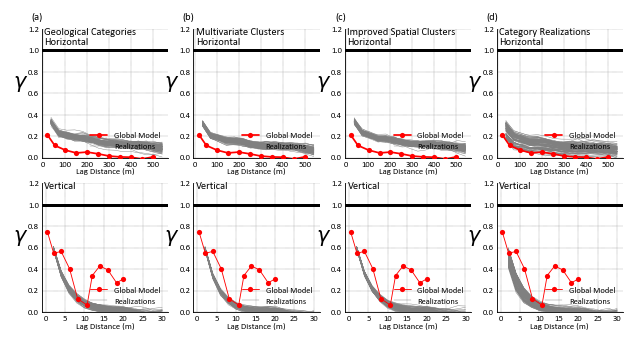

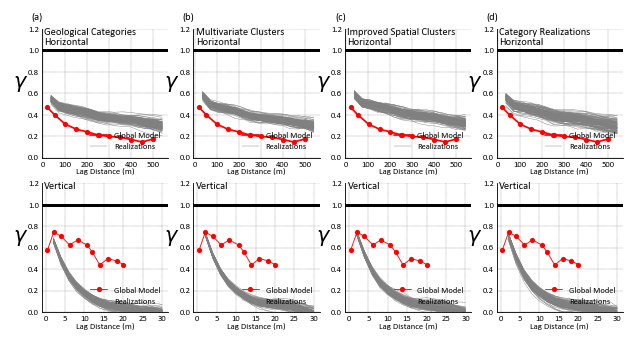

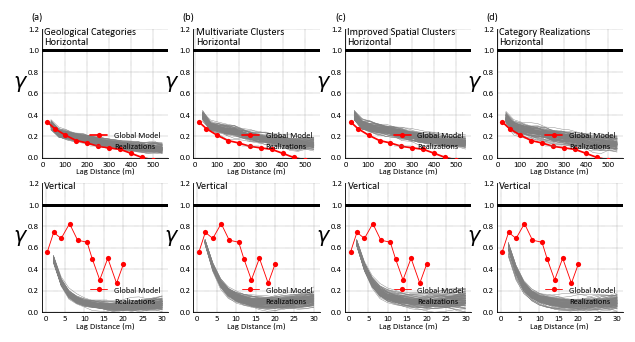

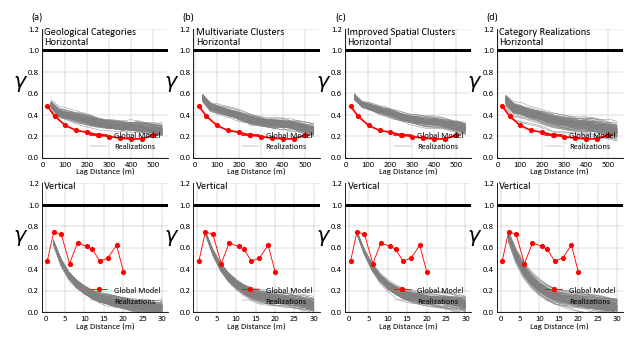

In [37]:
for var in variables: 
    nplot = 4
    outeraxes = qf.nestedax((2, nplot), order='row', figsize=(6 * (nplot / 4), 3))
    for iname, (name, axs) in enumerate(zip(names.keys(), outeraxes)):
        refvario = gg.VarModel(ouvarmodels['nodomains', 1, var])
        simvarios = results[name, var]
        axs = plotvarsim(simvarios, expvarios[var].varcalcdata[var], names[name], axs)   
        qf(axs[0], fignum=iname, lblxy=(0.01, 1.06), lblha='right')
    qf(outeraxes, fs=5)
    for ax in traverse(outeraxes):
        ax.set_ylabel('$\\gamma$', fontsize=12)
        ax.yaxis.labelpad = 4.5
    exp.exportfigure(f'varsim_{var}_top.pdf')
    plt.show()